In [2]:
import pandas as pd
import numpy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
genres = ['blues', 'classical', 'country', 'electronic_complete', 'heavy-metal', 'hip-hop', 'indie', 'k-pop', 'pop',
               'punk', 'reggae', 'reggaeton_complete', 'rock', 'r-n-b', 'salsa_complete']

#genres = ['electronic_complete','reggaeton_complete','salsa_complete']

all_data = pd.DataFrame([])
for count,genre in enumerate(genres):
    try:
        data = pd.read_csv("data/{genre}_lyrics.csv".format(genre=genre))
    except:
        continue
    if count == 0:
        all_data = data[:200]
    else:
        all_data = pd.concat([all_data,data[:200]],axis=0)

In [4]:
df = all_data[~all_data['lyrics'].isnull()]

In [5]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', encoding='latin-1', ngram_range=(1, 2))
features = tfidf.fit_transform(df.lyrics).toarray()
labels = df.song_genre

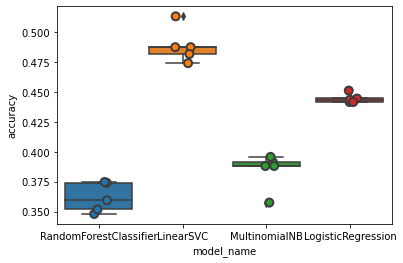

In [6]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()